# Merging SRXs

In [14]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.io import add_table
from ncbi_remap.plotting import make_figs
from ncbi_remap.prealn_wf import srr_per_srx, srx_reproducibility_score
from ncbi_remap.normalization import cpm

# Setup notebook
nbconfig = Nb.setup_notebook(nb_name='prealn-wf_merge_srr')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../sra.h5')

# Constants
from ncbi_remap.prealn_wf import SPEARMAN_CUTOFF

last updated: 2017-12-13 
Git hash: 7f6244abd2860817c178a98e105de5efb13092b0


In the SRA, runs (SRR) are considered technical replicates. However, we have found instances where users have uploaded biological replicates or different samples as the same SRX. We want to provide browser tracks and summarized coverage counts at the library (SRX) level, requiring SRRs to be merged. Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. I have explored multiple criteria (including SERE), but I have settled on using pairwise Spearman correlation using genes with at least 1 read. Here I require a correlation of ≥0.95 for an SRR to be considered a technical replicate. I also require that all SRRs within an SRX behave like technical replicates. There are cases where an SRX has 3 or more SRR with a small fraction behaving differently. Currently I am excluding these SRXs, but it may be worth while to try to create pseudo SRXs made up of these different groups of SRRs that behave similarly.

## Number of SRRs Per SRX

The majority of SRXs (n=17,072) have a single SRR. For the remaning 2,602 SRXs.

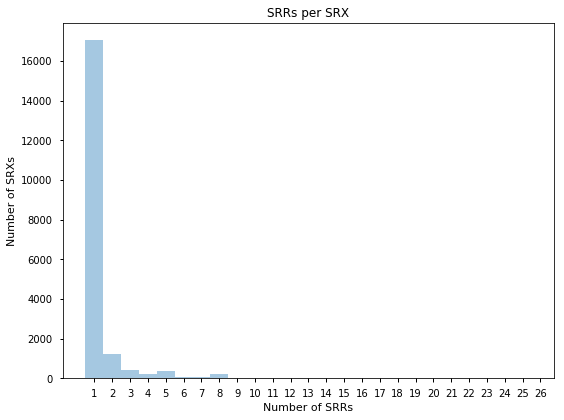

In [2]:
# Plot distribution of proportion uniquely mapping reads.
@make_figs(nbconfig.fig_name('histogram_number_srr_per_srx'), styles=nbconfig.styles, 
           formats=nbconfig.formats)
def plot(store):
    df = srr_per_srx(store).iloc[:, 0]
    bins = list(range(1, df.value_counts().index.max() + 1))
    fig, ax = plt.subplots(1, 1)
    sns.distplot(df, bins=bins, ax=ax, kde=False, hist_kws={'align': 'left'})
    ax.set_title('SRRs per SRX')
    ax.set_ylabel('Number of SRXs')
    ax.set_xlabel('Number of SRRs')
    ax.set_xticks(bins)
    return fig

plot(store)

In [3]:
# Make Flags
srx_counts = srr_per_srx(store)
single_srr_srx = srx_counts[(srx_counts == 1)['srr']].index.tolist()
two_srr_srx = srx_counts[(srx_counts == 2)['srr']].index.tolist()
multi_srr_srx = srx_counts[(srx_counts > 2)['srr']].index.tolist()

flag_srx_merge = set(single_srr_srx)

# Table of counts
df_num_srr = srx_counts.srr.value_counts().apply(lambda x: '{:,}'.format(x)).to_frame()
df_num_srr.index.name = 'Number of SRR'
df_num_srr.columns=['Number SRXs']
df_num_srr

,Number SRXs
Number of SRR,
1,"17,072"
2,"1,216"
3,433
5,362
8,222
4,192
6,85
7,61
9,14


## Pairs of SRX

I started by looking at SRXs with a pair of SRRS (n=1,216). The majority of these samples (n=858) have a Spearman correlation ≥0.95 and should be merged. The remaining 358 will be removed from further analysis for now.

In [4]:
@memory.cache
def calc_score(srxs, method='spearman', multi='pairwise', TH=1, show_warn=True, **kwargs):
    dfs = []
    for srx in srxs:
        dfs.extend(srx_reproducibility_score(store, srx, method=method, multi=multi, TH=TH, show_warn=show_warn, **kwargs))
        
    return pd.DataFrame(dfs, columns=['srx', 'srrs', method])

In [5]:
# Calculate correalation and count ok
pair_th1 = calc_score(two_srr_srx, TH=1)
pair_th1_ok = (pair_th1['spearman'] >= .95)

_df = pair_th1_ok.value_counts().to_frame()
_df.index = _df.index.map(lambda x: {True: 'Merge (≥0.95)', False: 'Drop (<0.95)'}[x])
_df.columns = ['Number of SRX']
print('Cutoff: {}'.format(SPEARMAN_CUTOFF))
_df.sort_index()

Cutoff: 0.95


,Number of SRX
Drop (<0.95),358
Merge (≥0.95),858


In [6]:
flag_srx_merge |= set(pair_th1.srx[pair_th1_ok].values)

## More than 2 SRR per SRX

Next I looked at the 1,386 SRXs that have 3 or more SRRs. Here I find 261 SRX that have a Spearman correlation ≥0.95 among all SRRs. The remaining 1,125 SRXs will be removed from further analysis. I breifly looked at these SRX that show some SRR with low correlation. There are a number of SRXs with a fraction of SRRs with low correlation, while the remaining SRRs have higher correlation; or examples where it looks like two groups of samples were merged together into a single SRX. It would be nice to revist this but for now I am going to ignore these samples.

In [7]:
# Calculate correlation
multi_th1 = calc_score(multi_srr_srx, TH=1)
multi_th1_ok = (multi_th1.groupby('srx').spearman.min() >= SPEARMAN_CUTOFF)

_df = multi_th1_ok.value_counts().map(lambda x: '{:,}'.format(x)).to_frame()
_df.index = _df.index.map(lambda x: {True: 'Merge (≥{})'.format(SPEARMAN_CUTOFF), False: 'Drop (<{})'.format(SPEARMAN_CUTOFF)}[x])
_df.columns = ['Number of SRX']
print('Cutoff: {}'.format(SPEARMAN_CUTOFF))
_df.sort_index()

Cutoff: 0.95


,Number of SRX
Drop (<0.95),"1,125"
Merge (≥0.95),261


In [8]:
flag_srx_merge |= set(multi_th1_ok.index[multi_th1_ok].values)

In [9]:
# Create a list of mergable SRXs

In [10]:
mergable = store.select('prealn/complete', 'srx == flag_srx_merge')

In [11]:
add_table(store, 'prealn/workflow/merge', data=mergable, force=True, columns='all')

In [12]:
store.close()